In [1]:
%cd drive/MyDrive/Colab Notebooks/DGA

/content/drive/MyDrive/Colab Notebooks/DGA


In [58]:
! pip install tensorflow

In [62]:
import numpy as np
import pandas as pd
import re
import random
import gc
import math
import collections
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score
from keras.preprocessing import sequence
from keras.models import Sequential
# from keras.layers.core import Dense, Dropout, Activation
# from keras.layers.embeddings import Embedding
# from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Embedding
from keras.layers import LSTM, Conv1D, MaxPooling1D, Input, Flatten
from keras import regularizers


RANDOM_SEED = 1

%matplotlib inline

In [29]:
benign_domain = pd.read_csv('data/benign_domain.csv')
benign_domain.describe()
dga_domain = pd.read_csv('data/360_dga_domain.csv')
dga_domain.describe()
bambenek_dga_domain = pd.read_csv('data/bambenek_dga_domain.csv')
bambenek_dga_domain.describe()

,DGA_family,Domain,Type
count,846616,846616,846616
unique,35,828202,1
top,banjori,mnktbeuuktipsl.com,DGA
freq,439223,62,846616


In [27]:
benign_domains = benign_domain['Domain'].tolist()
dga_domains = dga_domain['Domain'].tolist() + bambenek_dga_domain['Domain'].tolist()

In [31]:
X = benign_domains + dga_domains

In [32]:
unique_chars = enumerate(set(''.join(X)))
chars_dict = dict()
for i, x in unique_chars: #index of enum starts with 0
    #print('i: ' + str(i) + '  x: ' + x)
    chars_dict[x] = i + 1 #leave 0 for padding

In [33]:
#index 0 is also going to be a feature(padding/unknown).
max_features_num = len(chars_dict) + 1
max_features_num

40

In [34]:
# Convert characters to int
X_in_int = []
for domain in X:
    domain_in_int = []
    for c in domain:
        domain_in_int.append(chars_dict[c])
    X_in_int.append(domain_in_int)

In [35]:
X_in_int[1]

[37, 9, 12, 20, 12, 33, 24, 28, 39, 9, 6]

In [36]:
X[1]

'youtube.com'

In [38]:
#update X
X = X_in_int

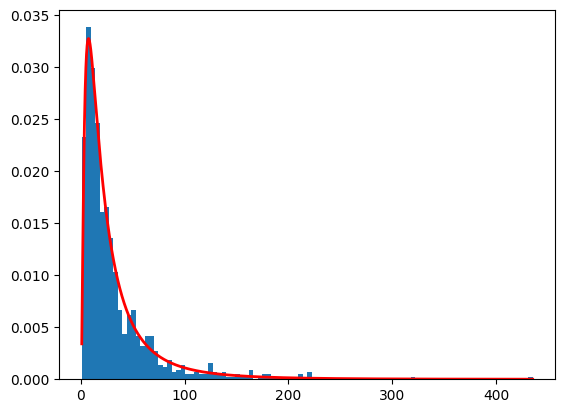

In [41]:
mu, sigma = 3., 1. # mean and standard deviation
s = np.random.lognormal(mu, sigma, 1000)
count, bins, ignored = plt.hist(s, 100, density=True, align='mid')
x = np.linspace(min(bins), max(bins), 10000)
pdf = (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2))
      / (x * sigma * np.sqrt(2 * np.pi)))
plt.plot(x, pdf, linewidth=2, color='r')
plt.axis('tight')
plt.show()

In [42]:
#max length will be the max length of domain in our dataset
maxlen = np.max([len(x) for x in X])
maxlen

73

In [44]:
#pad to max length
X = sequence.pad_sequences(X, maxlen=maxlen)
X.shape

(3016336, 73)

In [74]:
#Generate corresponding Y, 0 for 'benign'; 1 for 'dga'
Y = np.hstack([np.zeros(len(benign_domains)),np.ones(len(dga_domains))])

In [63]:
def build_model(max_features_num, maxlen):
    """Build LSTM model"""
    model = Sequential()
    model.add(Embedding(max_features_num, 64, input_length=maxlen))
    model.add(LSTM(64))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['binary_crossentropy','acc'])

    return model

In [64]:
pos_neg_cutpoint = len(benign_domains)
print("The cut point will be "+ str(pos_neg_cutpoint))

The cut point will be 1000000


In [65]:
#set new sampling szie as 300K
sampling_size = 150000

pos_indices = random.sample(range(pos_neg_cutpoint),sampling_size)
neg_indices = random.sample(range(pos_neg_cutpoint, len(X)),sampling_size)

In [75]:
new_X = X[pos_indices + neg_indices]
new_Y = Y[pos_indices + neg_indices]
new_X.shape

(300000, 73)

In [76]:
#training parameters
max_epoch=25
nfolds=10
batch_size=128

In [78]:
#call backs
from keras.callbacks import EarlyStopping
cb = []

cb.append(EarlyStopping(monitor='val_loss',
                        min_delta=0, #an absolute change of less than min_delta, will count as no improvement
                        patience=5, #number of epochs with no improvement after which training will be stopped
                        verbose=0,
                        mode='auto',
                        baseline=None,
                        restore_best_weights=False))

In [79]:
model = build_model(max_features_num, maxlen)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 73, 64)            2560      
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
 activation_1 (Activation)   (None, 1)                 0         
                                                                 
Total params: 35649 (139.25 KB)
Trainable params: 35649 (139.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [81]:
history = model.fit(x=new_X, y=new_Y,
                    batch_size=batch_size,
                    epochs=max_epoch,
                    verbose=1,
                    callbacks=cb,
                    validation_split=0.2, #
                    validation_data=None,
                    shuffle=True,
                    class_weight=None,
                    sample_weight=None,
                    initial_epoch=0,
                    steps_per_epoch=None,
                    validation_steps=None)

Epoch 1/25
  61/1875 [..............................] - ETA: 2:54 - loss: 0.0135 - binary_crossentropy: 0.0135 - acc: 0.9956

KeyboardInterrupt: 

In [82]:
model.save('LSTM_on_300K')

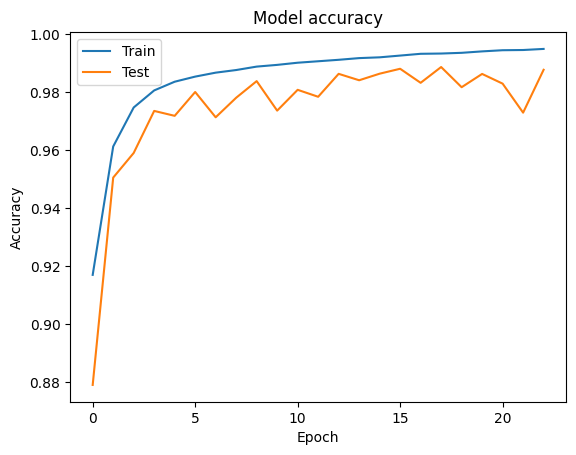

In [83]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

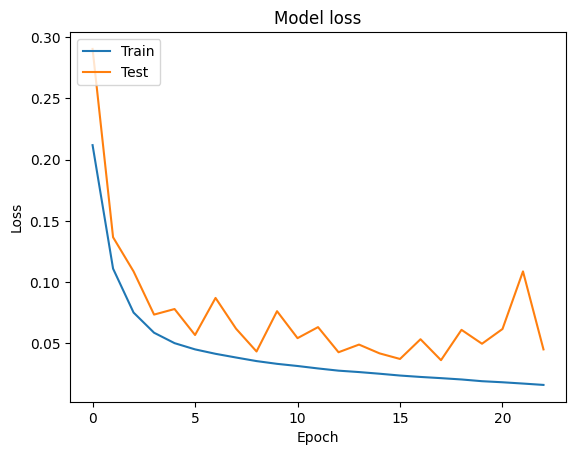

In [84]:

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()